Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import random
from sklearn.metrics import f1_score, recall_score
import matplotlib.pyplot as plt
import os
import json

Device Configuration

In [2]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda:0


Data Prep

In [3]:
# Download and load the CIFAR-100 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set = datasets.CIFAR100(root='../data', train=True, download=True, transform=transform)
test_set = datasets.CIFAR100(root='../data', train=False, download=True, transform=transform)

# Split train data into train and validation
train_size = int(0.8 * len(train_set))
val_size = len(train_set) - train_size
train_dataset, val_dataset = random_split(train_set, [train_size, val_size])

batch_size = 1024
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

100.0%


Extracting ../data\cifar-100-python.tar.gz to ../data
Files already downloaded and verified


Set Random Seed

In [4]:
# Function to set a random seed for reproducibility
def set_seed(seed=None):
    if seed is None:
        seed = np.random.randint(0, 10000)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    return seed

Validation

In [5]:
# Function for validation
def validate(net, val_loader, criterion):
    total_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    return total_loss / len(val_loader)

Calculate Test Error

In [6]:
# Function to calculate test error
def calculate_test_error(net, test_loader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy = 100 * correct / total
    return 100 - test_accuracy  # Test error

Train Model

In [7]:
# Function for training
def train_model(net, train_loader, val_loader, test_loader, criterion, optimizer, epochs):
    train_losses = []
    val_losses = []
    test_errors = []
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        train_losses.append(running_loss / len(train_loader))
        val_loss = validate(net, val_loader, criterion)
        val_losses.append(val_loss)
        test_error = calculate_test_error(net, test_loader)
        test_errors.append(test_error)
        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}, Test Error: {test_errors[-1]}')

    return train_losses, val_losses, test_errors

Metrics Calculation

In [8]:
# Function to calculate accuracy, F1 score, and recall
def calculate_metrics(net, loader):
    net.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for data in loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    return accuracy, f1, recall

Model Architecture

In [9]:
# ResNet-18 with no pre-trained weights
def initialize_model(device):
    net = models.resnet18(weights=None)
    num_features = net.fc.in_features

    # Adjusting for 10 classes in CIFAR-100
    net.fc = torch.nn.Linear(num_features, 100)
    net = net.to(device)

    return net

Loss Function

In [10]:
def initialize_loss_function():
    return nn.CrossEntropyLoss()

Optimizer

In [11]:
def initialize_optimizer(model_params):
    return optim.SGD(model_params, lr=0.001)

Run

Run: 1
Seed: 4042
Epoch 1/200, Train Loss: 4.843607747554779, Validation Loss: 4.805338764190674, Test Error: 98.72
Epoch 2/200, Train Loss: 4.705534482002259, Validation Loss: 4.6727612018585205, Test Error: 98.54
Epoch 3/200, Train Loss: 4.621841382980347, Validation Loss: 4.6203389167785645, Test Error: 97.92
Epoch 4/200, Train Loss: 4.560816180706024, Validation Loss: 4.584095239639282, Test Error: 97.44
Epoch 5/200, Train Loss: 4.515712332725525, Validation Loss: 4.5459174633026125, Test Error: 96.61
Epoch 6/200, Train Loss: 4.466433429718018, Validation Loss: 4.502259588241577, Test Error: 95.98
Epoch 7/200, Train Loss: 4.41328616142273, Validation Loss: 4.460806846618652, Test Error: 95.41
Epoch 8/200, Train Loss: 4.3596804022789, Validation Loss: 4.415708827972412, Test Error: 94.76
Epoch 9/200, Train Loss: 4.303830027580261, Validation Loss: 4.367472076416016, Test Error: 94.48
Epoch 10/200, Train Loss: 4.257229256629944, Validation Loss: 4.324249744415283, Test Error: 93.95
E

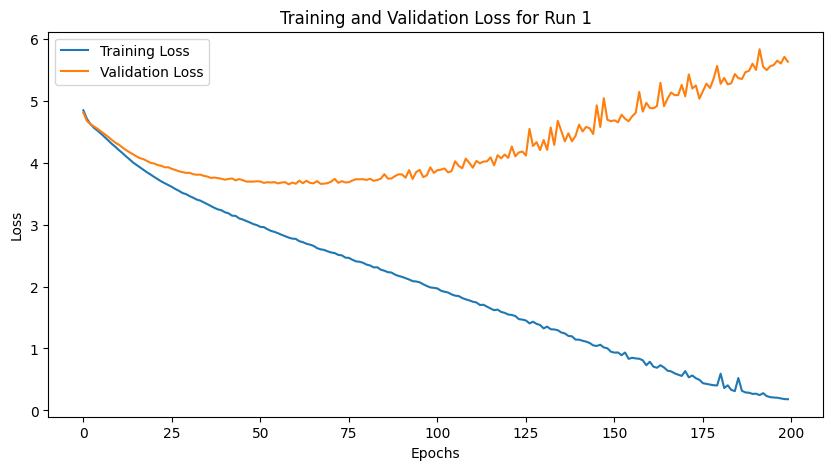

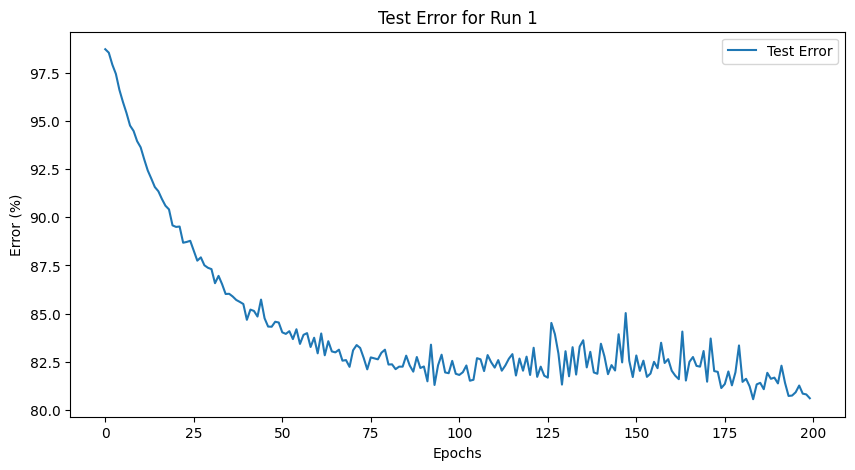

Run: 2
Seed: 531
Epoch 1/200, Train Loss: 4.854988288879395, Validation Loss: 4.803968620300293, Test Error: 98.84
Epoch 2/200, Train Loss: 4.68602534532547, Validation Loss: 4.662546873092651, Test Error: 98.52
Epoch 3/200, Train Loss: 4.607356369495392, Validation Loss: 4.603082370758057, Test Error: 97.74
Epoch 4/200, Train Loss: 4.54382039308548, Validation Loss: 4.552401828765869, Test Error: 96.75
Epoch 5/200, Train Loss: 4.481868815422058, Validation Loss: 4.497596359252929, Test Error: 96.11
Epoch 6/200, Train Loss: 4.417351496219635, Validation Loss: 4.447706079483032, Test Error: 95.62
Epoch 7/200, Train Loss: 4.357326805591583, Validation Loss: 4.3929667472839355, Test Error: 94.8
Epoch 8/200, Train Loss: 4.302567791938782, Validation Loss: 4.348944473266601, Test Error: 94.3
Epoch 9/200, Train Loss: 4.243764388561249, Validation Loss: 4.299672651290893, Test Error: 93.82
Epoch 10/200, Train Loss: 4.192650890350341, Validation Loss: 4.255673027038574, Test Error: 93.2
Epoch 

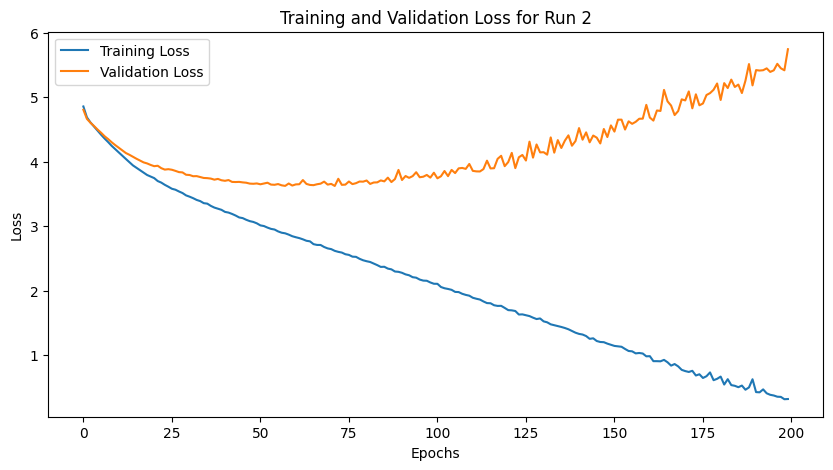

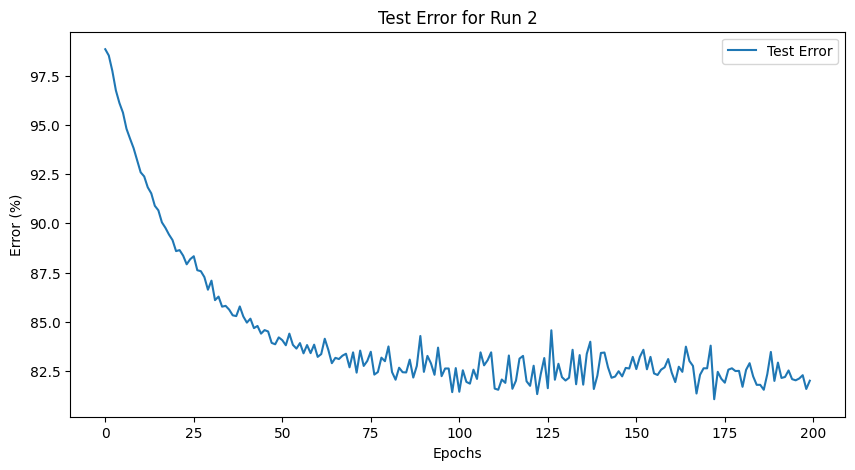

Run: 3
Seed: 288
Epoch 1/200, Train Loss: 4.850056827068329, Validation Loss: 4.825832271575928, Test Error: 98.72
Epoch 2/200, Train Loss: 4.689141392707825, Validation Loss: 4.672684288024902, Test Error: 98.54
Epoch 3/200, Train Loss: 4.620097351074219, Validation Loss: 4.6280711650848385, Test Error: 98.14
Epoch 4/200, Train Loss: 4.568678855895996, Validation Loss: 4.594560766220093, Test Error: 97.83
Epoch 5/200, Train Loss: 4.524893498420715, Validation Loss: 4.562753105163575, Test Error: 97.15
Epoch 6/200, Train Loss: 4.484791827201843, Validation Loss: 4.530375623703003, Test Error: 96.77
Epoch 7/200, Train Loss: 4.445229268074035, Validation Loss: 4.498310136795044, Test Error: 96.12
Epoch 8/200, Train Loss: 4.398373317718506, Validation Loss: 4.465512418746949, Test Error: 95.61
Epoch 9/200, Train Loss: 4.356051921844482, Validation Loss: 4.430650615692139, Test Error: 95.05
Epoch 10/200, Train Loss: 4.30778158903122, Validation Loss: 4.395022678375244, Test Error: 94.49
Ep

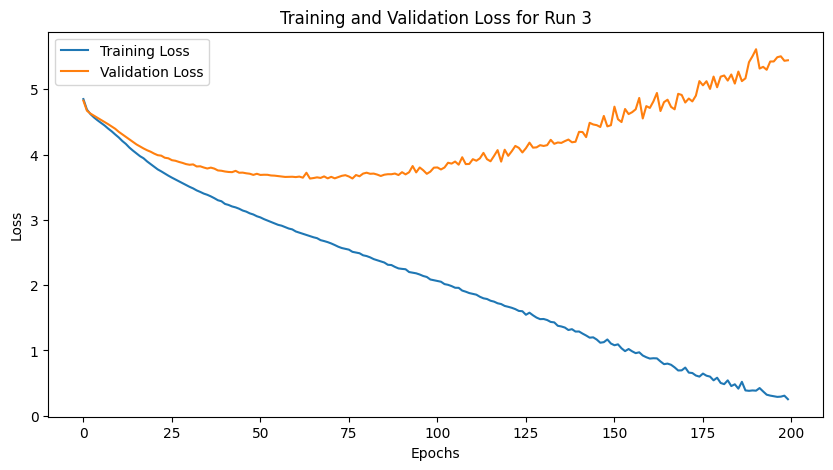

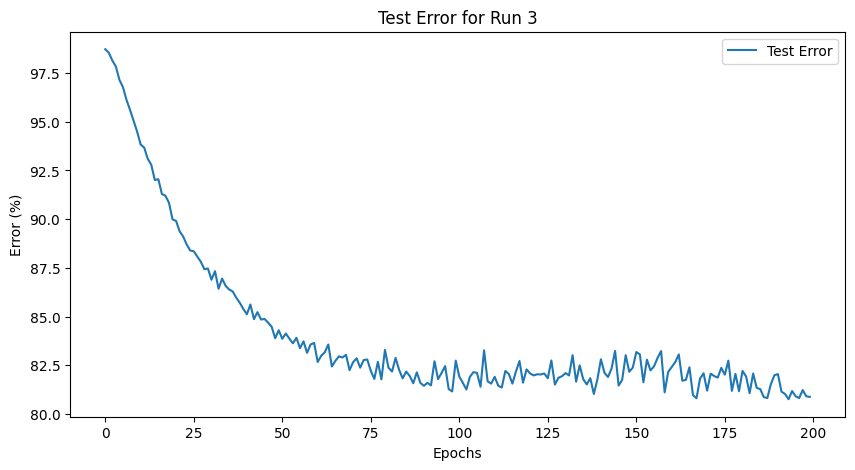

Run: 4
Seed: 5282
Epoch 1/200, Train Loss: 4.845344603061676, Validation Loss: 4.793792486190796, Test Error: 98.9
Epoch 2/200, Train Loss: 4.682017707824707, Validation Loss: 4.646941804885865, Test Error: 98.35
Epoch 3/200, Train Loss: 4.602924382686615, Validation Loss: 4.591462516784668, Test Error: 97.98
Epoch 4/200, Train Loss: 4.536735558509827, Validation Loss: 4.538188171386719, Test Error: 97.45
Epoch 5/200, Train Loss: 4.478122365474701, Validation Loss: 4.495217990875244, Test Error: 96.54
Epoch 6/200, Train Loss: 4.420233249664307, Validation Loss: 4.4532849311828615, Test Error: 95.87
Epoch 7/200, Train Loss: 4.368942844867706, Validation Loss: 4.411589241027832, Test Error: 95.35
Epoch 8/200, Train Loss: 4.317293787002564, Validation Loss: 4.375671911239624, Test Error: 95.11
Epoch 9/200, Train Loss: 4.271070897579193, Validation Loss: 4.339826869964599, Test Error: 94.52
Epoch 10/200, Train Loss: 4.228399455547333, Validation Loss: 4.307596445083618, Test Error: 93.85
E

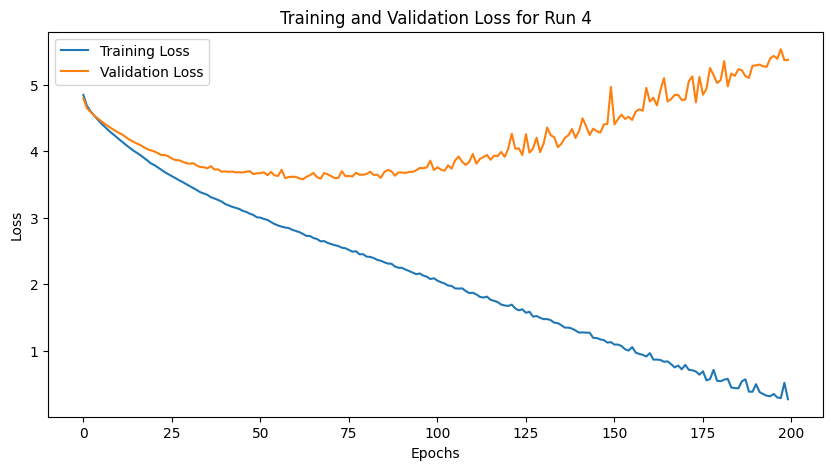

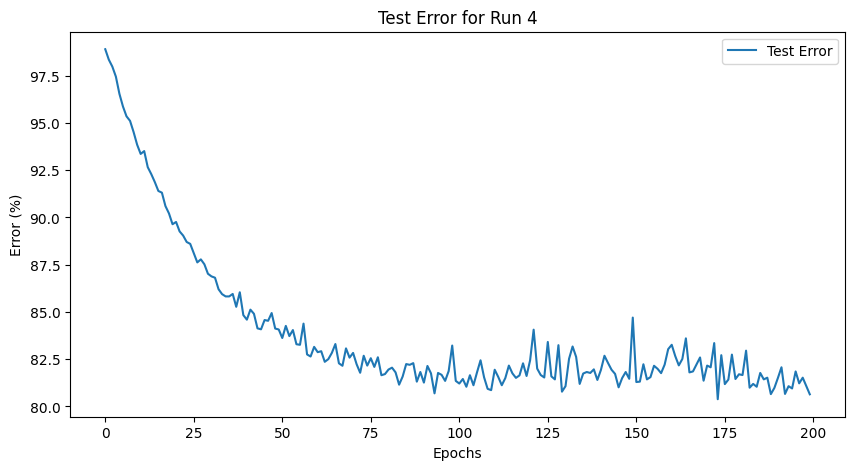

Run: 5
Seed: 6765
Epoch 1/200, Train Loss: 4.828294277191162, Validation Loss: 4.799284744262695, Test Error: 98.43
Epoch 2/200, Train Loss: 4.680598664283752, Validation Loss: 4.648534154891967, Test Error: 97.99
Epoch 3/200, Train Loss: 4.599162530899048, Validation Loss: 4.596770715713501, Test Error: 97.57
Epoch 4/200, Train Loss: 4.540831363201141, Validation Loss: 4.551940488815307, Test Error: 96.96
Epoch 5/200, Train Loss: 4.485611617565155, Validation Loss: 4.506185722351074, Test Error: 96.34
Epoch 6/200, Train Loss: 4.4351660966873165, Validation Loss: 4.4702956199646, Test Error: 95.88
Epoch 7/200, Train Loss: 4.382924866676331, Validation Loss: 4.427959966659546, Test Error: 95.29
Epoch 8/200, Train Loss: 4.334774100780487, Validation Loss: 4.399736404418945, Test Error: 94.87
Epoch 9/200, Train Loss: 4.294404327869415, Validation Loss: 4.361042261123657, Test Error: 93.99
Epoch 10/200, Train Loss: 4.242085921764374, Validation Loss: 4.322243070602417, Test Error: 93.47
Ep

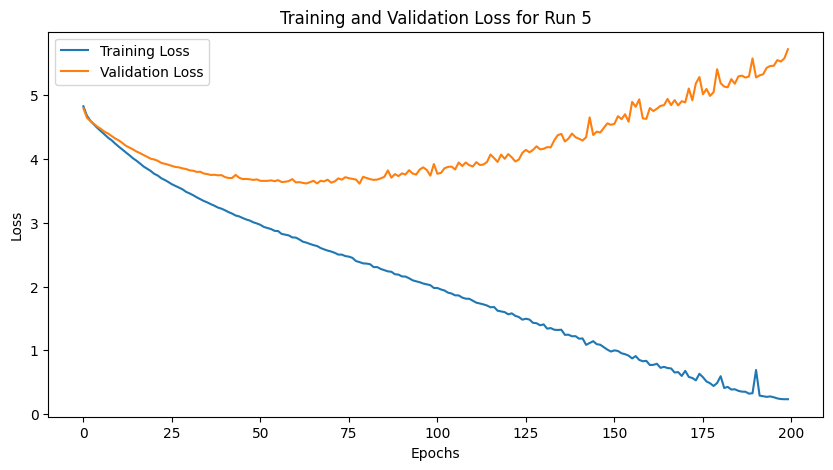

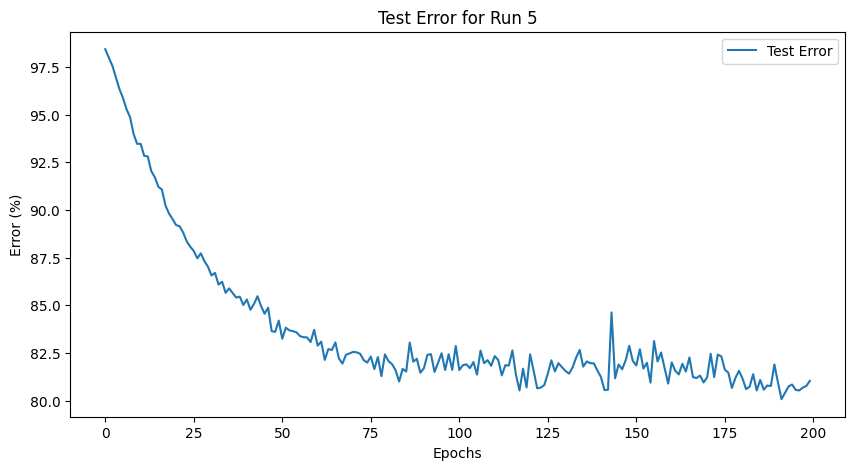

In [12]:
# Run the training for 5 different seeds
num_runs = 5
epochs = 200
metrics = {
    'seed': [],
    'train_losses': [],
    'val_losses': [],
    'test_errors': [],
    'val_accuracy': [],
    'val_f1': [],
    'val_recall': [],
    'test_accuracy': [],
    'test_f1': [],
    'test_recall': []
}

# Initialize dictionaries to store results
results = {
    'train_losses': [],
    'val_losses': [],
    'test_errors': []
}

for run in range(num_runs):
    print(f"Run: {run + 1}")
    seed = set_seed()
    print(f"Seed: {seed}")

    # Reinitialize the model, loss function, and optimizer
    net = initialize_model(device=device)
    criterion = initialize_loss_function()
    optimizer = initialize_optimizer(model_params=net.parameters())

    # Train the network
    train_losses, val_losses, test_errors = train_model(net, train_loader, val_loader, test_loader, criterion, optimizer, epochs)
    metrics['test_errors'].append(test_errors)

    # Calculate metrics on validation and test sets
    val_accuracy, val_f1, val_recall = calculate_metrics(net, val_loader)
    test_accuracy, test_f1, test_recall = calculate_metrics(net, test_loader)
    
    # Print metrics for validation set
    print(f"Run {run + 1} - Validation Metrics:")
    print(f"    Accuracy: {val_accuracy}%")
    print(f"    F1 Score: {val_f1}")
    print(f"    Recall:   {val_recall}")

    # Print metrics for test set
    print(f"Run {run + 1} - Test Metrics:")
    print(f"    Accuracy: {test_accuracy}%")
    print(f"    F1 Score: {test_f1}")
    print(f"    Recall:   {test_recall}")
    
    # Store metrics
    metrics['seed'].append(seed)
    metrics['train_losses'].append(train_losses)
    metrics['val_losses'].append(val_losses)
    metrics['val_accuracy'].append(val_accuracy)
    metrics['val_f1'].append(val_f1)
    metrics['val_recall'].append(val_recall)
    metrics['test_accuracy'].append(test_accuracy)
    metrics['test_f1'].append(test_f1)
    metrics['test_recall'].append(test_recall)
    
    # Append the results for the current run
    results['train_losses'].append(metrics['train_losses'][run])
    results['val_losses'].append(metrics['val_losses'][run])
    results['test_errors'].append(metrics['test_errors'][run])

    # Plot for training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(metrics['train_losses'][run], label='Training Loss')
    plt.plot(metrics['val_losses'][run], label='Validation Loss')
    plt.title(f"Training and Validation Loss for Run {run+1}")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot for test error
    plt.figure(figsize=(10, 5))
    plt.plot(metrics['test_errors'][run], label='Test Error')
    plt.title(f"Test Error for Run {run+1}")
    plt.xlabel('Epochs')
    plt.ylabel('Error (%)')
    plt.legend()
    plt.show()

Metrics Calculation and Plotting Mean Test Error

Mean Metrics: {'val_accuracy': 18.77, 'val_f1': 0.1851875273928873, 'val_recall': 0.1877, 'test_accuracy': 18.964, 'test_f1': 0.18553595788395258, 'test_recall': 0.18964}
Standard Deviation of Metrics: {'val_accuracy': 0.5378103755042294, 'val_f1': 0.007833386699114714, 'val_recall': 0.005378103755042292, 'test_accuracy': 0.5121171740920243, 'test_f1': 0.008040185628586731, 'test_recall': 0.005121171740920232}


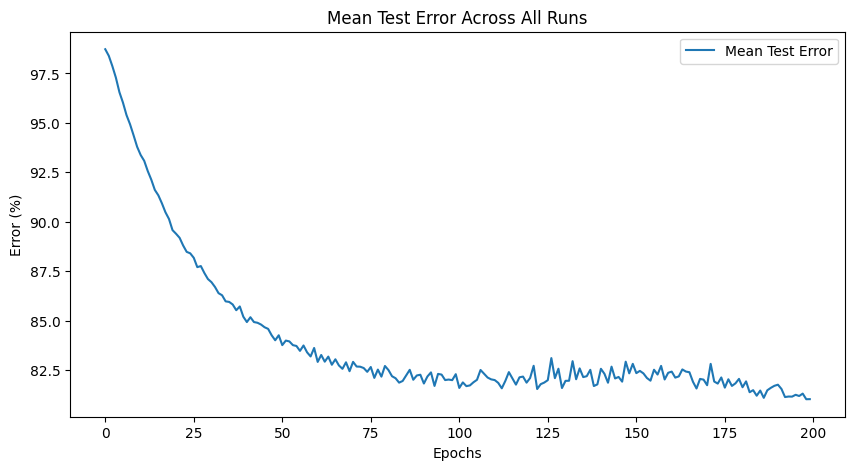

In [13]:
# Calculate mean and standard deviation across runs
mean_metrics = {metric: np.mean(metrics[metric]) for metric in metrics if metric not in ['seed', 'train_losses', 'val_losses', 'test_errors']}
std_metrics = {metric: np.std(metrics[metric]) for metric in metrics if metric not in ['seed', 'train_losses', 'val_losses', 'test_errors']}

# Print mean metrics and standard deviation
print("Mean Metrics:", mean_metrics)
print("Standard Deviation of Metrics:", std_metrics)

# Calculate mean test error across all runs
mean_test_errors = np.mean(metrics['test_errors'], axis=0)

# Plot mean test error
plt.figure(figsize=(10, 5))
plt.plot(mean_test_errors, label='Mean Test Error')
plt.title("Mean Test Error Across All Runs")
plt.xlabel('Epochs')
plt.ylabel('Error (%)')
plt.legend()
plt.show()

Save data

In [14]:
# Directory for saving results
save_dir = 'CIFAR_100_ResNet18_Results'
os.makedirs(save_dir, exist_ok=True)

# Save the results to a file
with open(os.path.join(save_dir, 'SGD.json'), 'w') as f:
    json.dump(results, f)